# Exploratory Data Analysis for Chunking

Retrieval Augementation and Generation (RAG) systems are increasingly common. Generally it is easy to implement a proof of concept that passes the infamous "vibe" check fairly quickly, whilst this might get an engineer 70-80% of the way, as with any data driven system, the devil really is in the details when it comes to squeezing out the extra performance that gives end users confidence.

The questions we'll look at include:
- What length should my chunks be?
- Should all of my chunks be the same size?
- What's the distribution of my chunk lengths?
- How should I consider the relationship between my chunk length, and the context window in my generation step?
- Do my chunks make sense in the context of my business problem?
- Is semantic purity important for my chunks? How do I measure it?

This notebook aims to give direction to data professionals in how they might approach evaluating, and selecting a chunking methodology for a RAG system. 

This notebook does NOT intend on covering end to end evaluation of RAG systems, as that is a much broader topic that dives into information retrieval. Resources for tuning those elements of a RAG system can be found [here]().

Let's load some data and get started!


## Loading a corpus
First things first, let's load some text data to work with. Let's go with the [pubmed summarisation dataset](https://huggingface.co/datasets/ccdv/pubmed-summarization). We'll download from hugging face, but for simplicity we'll convert the dataset to pandas, which most data pro's are familiar with.


In [7]:
from datasets import load_dataset
from uuid import uuid4
from pprint import pprint
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tiktoken as tk
import random
import json
from multiprocessing import Pool

# Set to pubmed or arxiv
publication = 'pubmed'

dataset = load_dataset(f'ccdv/{publication}-summarization',split='validation',trust_remote_code=True)

# Convert to a pandas dataframe and do some housekeeping
ds = dataset.to_pandas()
ds['doc_id'] = [str(uuid4()) for _ in range(len(ds))]
ds['article_len'] = ds['article'].apply(lambda x: len(x.split()))
ds['abstract_len'] = ds['abstract'].apply(lambda x: len(x.split()))

ds.head()

,article,abstract,doc_id,article_len,abstract_len
0,venous thromboembolism ( vte ) comprising of d...,background and aim : there is lack of substant...,3f196c33-0c09-4125-afed-fbefccbba1b2,4320,332
1,there is an epidemic of stroke in low and midd...,backgroundthe questionnaire for verifying stro...,2b6044d7-ad51-48ec-94ac-df6ca46ef041,3485,206
2,cardiovascular diseases account for the highes...,background : timely access to cardiovascular h...,f720adaf-f11f-416b-b47c-3a846d9a94ed,2939,172
3,results of a liquid culturing system ( bd bact...,to determine differences in the ability of myc...,5750efc4-b496-44b6-9a84-6085e5834ba9,1287,65
4,the need for magnetic resonance imaging ( mri ...,aimsour aim was to evaluate the potential for ...,477a9998-9bfa-4b44-a534-300222461a4d,5631,251


Let's take a look at the distribution of article and abstract lengths.

In [8]:
ds.describe()

,article_len,abstract_len
count,6633.000000,6633.000000
mean,3112.306799,202.902910
std,2776.940754,79.407822
min,0.000000,18.000000
25%,1523.000000,141.000000
50%,2609.000000,209.000000
75%,4011.000000,263.000000
max,119269.000000,518.000000


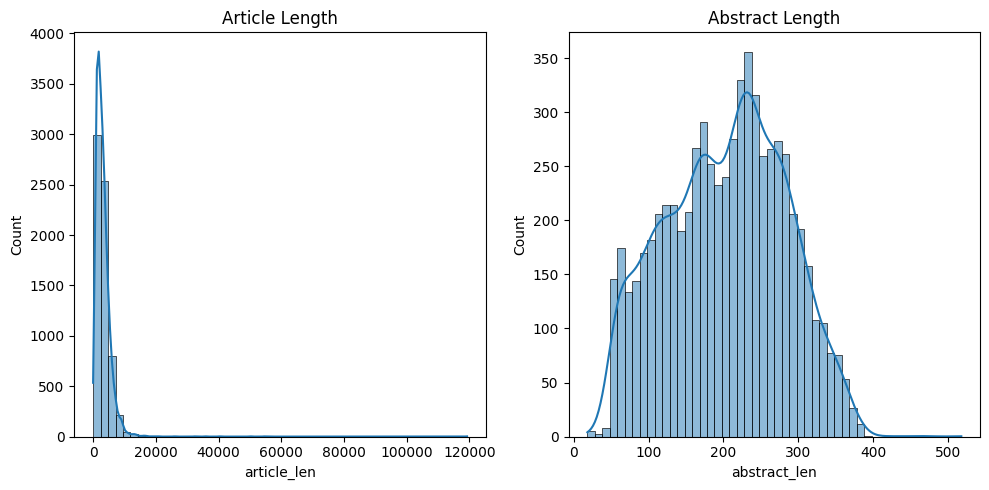

In [9]:
# Lets plot a histogram with seaborn

# Create a figure and a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first histogram on the first subplot
sns.histplot(ds['article_len'], bins=50, kde=True, ax=axs[0])
axs[0].set_title('Article Length')

# Plot the second histogram on the second subplot
sns.histplot(ds['abstract_len'], bins=50, kde=True, ax=axs[1])
axs[1].set_title('Abstract Length')

# Display the plots
plt.tight_layout()
plt.show()

Before we even start diving deeper, we can see the heavy right skew of the article length distribution. For now, let's take a closer look at the length percentiles to see what might make dor a good cutoff.

In [10]:
ds.describe(percentiles=[0.75,0.8, 0.9,0.95, 0.99])

,article_len,abstract_len
count,6633.000000,6633.000000
mean,3112.306799,202.902910
std,2776.940754,79.407822
min,0.000000,18.000000
50%,2609.000000,209.000000
75%,4011.000000,263.000000
80%,4439.400000,276.000000
90%,5661.000000,305.000000
95%,6967.800000,330.000000
99%,10231.720000,362.680000


The problem is definitely in the high end of town, with a jump from 10k to 112k in number of words for the last percentile. Let's take a closer look at the raw data and see if we can tell what's going on.

In [11]:
# Get the indices of the articles with the longest length
longest_articles = ds['article_len'].nlargest(5).index
for idx in longest_articles:
    print(f'Article Length: {ds["article_len"][idx]}\n')
    print(ds['article'][idx]+'\n')
    print('\n')

Article Length: 119269

the motion of a point electric charge in flat spacetime was the subject of active investigation since the early work of lorentz , abrahams , and poincar , until dirac   produced a proper relativistic derivation of the equations of motion in 1938 . 
 ( the field s early history is well related in . ) in 1960 dewitt and brehme   generalized dirac s result to curved spacetimes , and their calculation was corrected by hobbs   several years later . in 1997 the motion of a point mass in a curved background spacetime 
 was investigated by mino , sasaki , and tanaka , who derived an expression for the particle s acceleration ( which is not zero unless the particle is a test mass ) ; the same equations of motion were later obtained by quinn and wald   using an axiomatic approach . 
 the case of a point scalar charge was finally considered by quinn in 2000 , and this led to the realization that the mass of a scalar particle is not necessarily a constant of the motion . 
 

At first glance, it appears that the two main causes of long documents are either:
- LaTeX package inclusions (mathematical formatting for scientific documents)
- Data tables (from pharmaceutical research by the look of it)

In practice we would want to spend more time understanding the drivers behind the outliers, and address as many as possible. Given this is an **information retrieval** promlem we want to avoid excluding valid records. 

However, for the purposes of this exercise we will focus on the LaTeX issue. Data tables could be solved through an application of difference pdf cracking techniques (e.g. [Azure Document Intelligence](https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/concept-retrieval-augmented-generation?view=doc-intel-4.0.0)), but that is out of scope for this notebook.

Let's remove the the lines which include LaTeX and take another look at the adjusted distributions.

In [12]:
from utils.general import remove_latex_packages

# Remove LaTeX package inclusions from the articles
ds['article'] = ds['article'].apply(remove_latex_packages)

# Recalculate article lengths
ds['article_len'] = ds['article'].apply(lambda x: len(x.split()))

display(ds.describe(percentiles=[0.75,0.8, 0.9,0.95, 0.99]))

,article_len,abstract_len
count,6633.000000,6633.000000
mean,3105.276195,202.902910
std,2623.569741,79.407822
min,0.000000,18.000000
50%,2609.000000,209.000000
75%,4011.000000,263.000000
80%,4437.000000,276.000000
90%,5658.400000,305.000000
95%,6954.400000,330.000000
99%,10187.320000,362.680000


This has made a difference, but 97k is still very large. For now, let's exclude the longer documents, storing them in another dataframe for analysis later.

Once we remove the odd docs, we'll check our distribution again to make sure that we now have something workable.

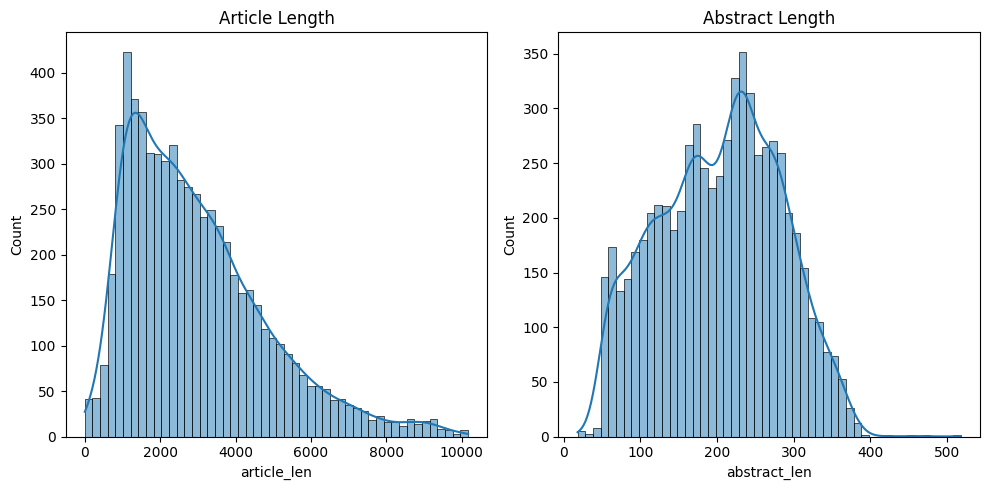

,article_len,abstract_len
count,6566.000000,6566.000000
mean,2968.537009,202.820286
std,1850.057023,79.503697
min,0.000000,18.000000
25%,1516.000000,141.000000
50%,2578.500000,209.000000
75%,3947.750000,263.000000
max,10171.000000,518.000000


In [13]:
from utils.general import remove_over_percentile

#apply helper function from utils module
ds_99pct, ds_outliers = remove_over_percentile(ds, 'article_len', .99)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first histogram on the first subplot
sns.histplot(ds_99pct['article_len'], bins=50, kde=True, ax=axs[0])
axs[0].set_title('Article Length')

# Plot the second histogram on the second subplot
sns.histplot(ds_99pct['abstract_len'], bins=50, kde=True, ax=axs[1])
axs[1].set_title('Abstract Length')

# Display the plots
plt.tight_layout()
plt.show()

display(ds_99pct.describe())

## Let's get chunking!

Now we know the distribution of our document lengths, we can start to look at how to approach chunking. Remember our questions were:

- What length should my chunks be?
- Should all of my chunks be the same size?
- What's the distribution of my chunk lengths?
- How should I consider the relationship between my chunk length, and the context window in my generation step?
- Do my chunks make sense in the context of my business problem?
- Is semantic purity important for my chunks? How do I measure it?

Let's start with the first question. There won't be a one size fits all answer here, but there will be "non functional" considerations. We now know that our mean article length is about `3000` words, and the max is ~`10,000` words. What does that tell us?
1. the number of calls that we need to make to an embedding service will be `3000 / chunk_size'
2. Whilst we could fit entire documents into the generation step of RAG using models with a large context window (e.g. Claude 3 - Opus) - we probably don't want to

> **Note: Words and tokens**: *Despite feeling like LLMs converse in our language, there's a few things that go in behind the scenes that translate our verbiage into something an algorithm understands. Firstly, the text is `tokenized`, which means words are split into a list of `tokens`. Think of this a bit like stemming in NLP. For shorter words, the ratio of tokens to words can be 1:1 (i.e. the word = the token), but for longer, or more complex words the ratio can be far higher. These lists are then converted into numerical vectors that the algorithm can understand. For a given corpus, we could work out the exact ratio - in fact, let's do that!*



In [14]:
# run the tokeniser over the articles and abstracts and store the results in the DataFrame
encoding = tk.encoding_for_model('gpt-3.5-turbo')

article_tokens = ds_99pct['article'].apply(encoding.encode)
abstract_tokens = ds_99pct['abstract'].apply(encoding.encode)


# check if columns already exist
if 'article_tokens' in ds_99pct.columns:
    ds_99pct = ds_99pct.drop(columns=['article_tokens'])
if 'abstract_tokens' in ds_99pct.columns:
    ds_99pct = ds_99pct.drop(columns=['abstract_tokens'])

ds_99pct = ds_99pct.assign(article_tokens=article_tokens, abstract_tokens=abstract_tokens)
ds_99pct['article_tk_len'] = ds_99pct['article_tokens'].apply(lambda x: len(x))
ds_99pct['abstract_tk_len'] = ds_99pct['abstract_tokens'].apply(lambda x: len(x))


Let's look at the distributions again. You could use a histogram, but I prefer box plots, or violin pots if I'm feeling fancy. These are great as the show the univariate stats (mean/median etc.) but also provide the same "distribution curve" visual that you'd get from a histogram. 

***----***---***---***
This is what we're working with:

Mean Article Tokens: 3805.0848309473045
Median Article Tokens: 3263.0
Mode Article Tokens: 2295
Mean Abstract Tokens: 263.03243984160827
Median Abstract Tokens: 263.0
Mode Abstract Tokens: 285
***----***---***---***


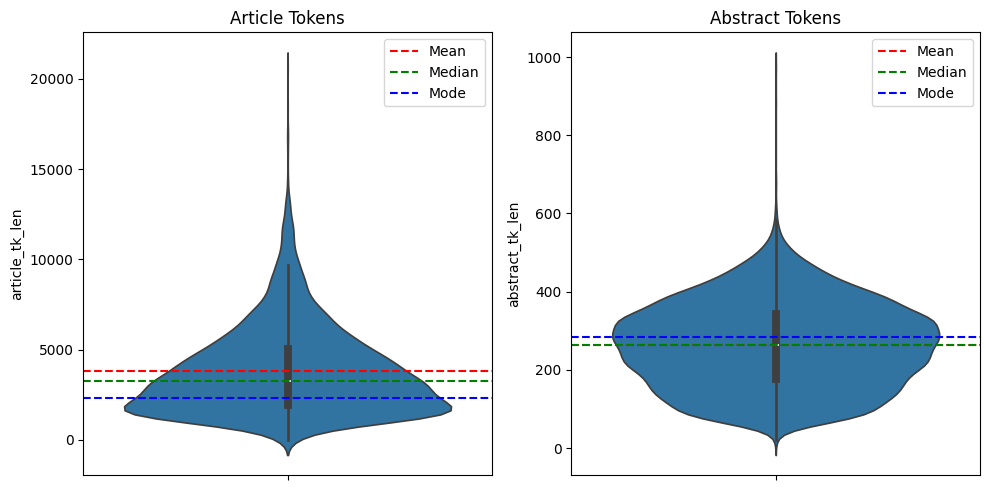

In [15]:
# Calculate the mean, median and mode for the token lengths
article_token_mean = ds_99pct['article_tk_len'].mean()
article_token_median = ds_99pct['article_tk_len'].median()
article_token_mode = ds_99pct['article_tk_len'].mode()[0]
abstract_tokens_mean = ds_99pct['abstract_tk_len'].mean()
abstract_tokens_median = ds_99pct['abstract_tk_len'].median()
abstract_tokens_mode = ds_99pct['abstract_tk_len'].mode()[0]

print("***----***---***---***")
print("This is what we're working with:\n")
print(f'Mean Article Tokens: {article_token_mean}')
print(f'Median Article Tokens: {article_token_median}')
print(f'Mode Article Tokens: {article_token_mode}')
print(f'Mean Abstract Tokens: {abstract_tokens_mean}')
print(f'Median Abstract Tokens: {abstract_tokens_median}')
print(f'Mode Abstract Tokens: {abstract_tokens_mode}')
print("***----***---***---***")

# Let's plot the token lengths as violin plots as two panels and call out the mean, median and mode
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first violin plot on the first subplot
sns.violinplot(y=ds_99pct['article_tk_len'], ax=axs[0])
axs[0].set_title('Article Tokens')
axs[0].axhline(article_token_mean, color='red', linestyle='--', label='Mean')
axs[0].axhline(ds_99pct['article_tk_len'].median(), color='green', linestyle='--', label='Median')
axs[0].axhline(ds_99pct['article_tk_len'].mode()[0], color='blue', linestyle='--', label='Mode')
axs[0].legend()

# Plot the second violin plot on the second subplot
sns.violinplot(y=ds_99pct['abstract_tk_len'], ax=axs[1])
axs[1].set_title('Abstract Tokens')
axs[1].axhline(abstract_tokens_mean, color='red', linestyle='--', label='Mean')
axs[1].axhline(ds_99pct['abstract_tk_len'].median(), color='green', linestyle='--', label='Median')
axs[1].axhline(ds_99pct['abstract_tk_len'].mode()[0], color='blue', linestyle='--', label='Mode')
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()


Let's go with our mean article token length of 3800, and article length of 3000 - which gives us a ratio of aproximately 1.25 or 5:4 for our specific corpus. 

# Why did do we care about this?

How many records do we want to include in our Augmentation step when constructing the generation prompt? Say we're using GPT-35-Turbo, we have aprx 4000 tokens to play with (for an explanation of tokens see [this](https://www.tokencounter.io/) excellent resource). This is both input and output.
Let's assume we have a prompt template which is a total of 500 tokens, including our guardrails, instructions and any other boiler plate commentary that needs to be input to the generation step. Say we then allow for up to 500 tokens in a response. This leaves us with 3000 tokens (or 2400 words) to play with. If we assume a chunk size (in number of words) of 400, that gives us ~6 records in our retrieval step. In fact, this might be a good starting point. Why not try baseline chunking with with this as a starting point.

In [16]:
# Let's now apply this to our dataset
from utils.general import chunk_string_with_overlap

# Create a new DataFrame with each chunk as a separate row
chunks = []
doc_ids = []
chunk_ids = []
for idx, row in ds_99pct.iterrows():
    article_chunks = chunk_string_with_overlap(input_text=row['article'], chunk_length=400, overlap=50)
    chunks.extend(article_chunks)
    doc_ids.extend([row['doc_id']] * len(article_chunks))
    chunk_ids.extend([f"{row['doc_id']}-{i+1}" for i in range(len(article_chunks))])

ds_chunked = pd.DataFrame({'doc_id': doc_ids, 'chunk_id': chunk_ids, 'chunks': chunks})

# Worl out the average number of chunks per document
avg_chunks_per_doc = ds_chunked.groupby('doc_id').size().mean()
print(f'Average number of chunks per document: {avg_chunks_per_doc}')

Average number of chunks per document: 8.841383513637057


## Now we have some chunks - let's start having fun

We have some operational concerns to deal with next. Before we can work out if the chunking strategy is any good, we will need to embed the chunks, and store them in a vector database. We'll then need to come up with some basic questions and answers to test the system - GPT4 is ideal for this. 

> Note: Whilst we could include a variety of search configurations to test, here we're only concerned with the relevance of the chunks compared to the question. We'll simplify the problem by simply measuring the cosine similarity of the question and answer for now.

For each document, we'll use GPT4 to generate 5 questions and answers as our test set. To save on time and money, we'll reduce the number of articles we're dealing with down to 50.

In [17]:
# select a random 50 unique doc_ids and subset both the ds_99pct and new_df dataframes using these IDs
random.seed(42)
random_doc_ids = random.sample(list(ds_99pct['doc_id'].unique()), 50)

# Subset the DataFrames
ds_subset = ds_99pct[ds_99pct['doc_id'].isin(random_doc_ids)]

ds_chunked_subset = ds_chunked[ds_chunked['doc_id'].isin(random_doc_ids)]

# Submit the articles to GPT-3.5-turbo for Q&A creation 
def generate_qa_prompt(article):
    prompt = f"""
    Given the following article, generate 5 Question/Answer pairs that could be used to test a student's understanding of the material:

    Article:\n
    {article}\n

    The output should be a list of dictionaries, with each question/answer pair structured as follows:
    {{
        "question": "What is the capital of France?",
        "answer": "Paris"
    }}

    Only provide the data in as describes, do not include any other information in the output.
    Ensure that the output is formatted as a list of dictionaries.
    Do not include markdown or any other formatting in the output e.g. no ```json.
    Do not generate questions that are too similar to each other.
    Do not generate questions that require external knowledge.
    """
    return prompt

prompts = [generate_qa_prompt(article) for article in ds_subset['article']]


In [18]:
# Multithreaded ~ 13x faster
#TODO: Add a check for the file, if it exists read it in, else do the hit the endpoint

from utils.openai_utils import general_prompt, create_client

client = create_client()

multi_threading = True

# Note changing this to 3.5 without implementing guardrails may result in malformed results...
model = 'gpt-4'

if multi_threading == True:
    def process_article(article):
        return general_prompt(client, generate_qa_prompt(article), model=model)

    with Pool() as pool:
        results_multiprocessing = pool.map(process_article, ds_subset['article'])

else:
    results = [general_prompt(client, prompt, model=model) for prompt in prompts]

# Print the first result
pprint(results_multiprocessing[0])


('[\n'
 '    {\n'
 '        "question": "What is the success rate for endourological management '
 'of UPJO?",\n'
 '        "answer": "The success rate does not exceed 80%."\n'
 '    },\n'
 '    {\n'
 '        "question": "When was laparoscopic pyeloplasty first introduced?",\n'
 '        "answer": "Laparoscopic pyeloplasty was first introduced in 1993."\n'
 '    },\n'
 '    {\n'
 '        "question": "What was the long-term follow-up period for the study '
 'of laparoscopic pyeloplasty presented in the article?",\n'
 '        "answer": "The long-term follow-up period was 36.5 months."\n'
 '    },\n'
 '    {\n'
 '        "question": "How was radiologic success defined in the study of '
 'laparoscopic pyeloplasty?",\n'
 '        "answer": "Radiologic success was defined as imaging of a patent UPJ '
 'on IVP and resolution of obstruction on a MAG-3 renal scan."\n'
 '    },\n'
 '    {\n'
 '        "question": "What was the overall success rate of laparoscopic '
 'pyeloplasty found in the 

In [19]:
# Convert a list of str into a list of dictionaries and store them as a file
from utils.general import convert_to_dict

qa_pairs = convert_to_dict(results_multiprocessing)

with open('data/qa_pairs.jsonl', 'w') as f:
    json.dump(qa_pairs, f, indent=4)

## Setting up the Retrieval step
### Check in
Where are we up to:
- We have a good understanding of our corpus and have done some housekeeping
- We understand tokens, and how our chunks are related to context length
- We have a chunked data set to act as a baseline
- We have generated some ground truth data to evaluate our chunks

What do we need to do next:
- Embed our data
- Store it in a vector database
- Query the db using our ground truth questions
- Generate a final response
- Run it through an evaluation framework
- ITERATE

Let's start with embeddings. There are many different embedding models out there. I'm going to assume that given we've used Azure Open AI, that we can also access an embedding model through the same resource. Be sure to have things configured in your `.env` file.


In [20]:
def generate_embeddings(text, model="text-embedding-ada-002"):
    return client.embeddings.create(input = [text], model=model).data[0].embedding

# if a column exists delete it
if 'ada_v2' in ds_chunked_subset.columns:
    ds_chunked_subset = ds_chunked_subset.drop(columns=['ada_v2'])

if multi_threading == True:
    with Pool() as pool:
        results_multiprocessing = pool.map(generate_embeddings, ds_chunked_subset['chunks'])
        ds_chunked_subset['ada_v2'] = results_multiprocessing

else:
    ds_chunked_subset['ada_v2'] = ds_chunked_subset["chunks"].apply(lambda x : generate_embeddings (x, model = 'text-embedding-ada-002'))

Now lets store these in a vector database. To keep things simple, we've elected to use ChromaDB, which is the "SQLLite" of the vector database world. Note, we could have skipped the above step and used ChromaDB's OpenAIEmbedding interface. We'll need to set this up to embed queries regardless.

In [ ]:
import chromadb.utils.embedding_functions as embedding_functions
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=os.getenv("AZURE_OPENAI_API_KEY"),
                api_base=os.getenv("AZURE_OPENAI_ENDPOINT"),
                api_type="azure",
                api_version=os.getenv("OPENAI_API_VERSION"),
                model_name="text-embedding-ada-002"
            )

In [ ]:
from chromadb import Client
chroma_client = Client()

# if chroma_client.list_collections()[0].name == "baseline_pubmed_articles":
#     chroma_client.delete_collection(name="baseline_pubmed_articles")

collection = chroma_client.create_collection(name="baseline_pubmed_articles",embedding_function=openai_ef, metadata={"hnsw:space": "cosine"})

collection.add(
    embeddings=ds_chunked_subset['ada_v2'].tolist(),
    documents=ds_chunked_subset['chunks'].tolist(),
    metadatas=[{"doc_id": doc_id} for doc_id in ds_chunked_subset['doc_id']],
    ids=ds_chunked_subset['chunk_id'].tolist()
)

In [ ]:
results = collection.query(
    query_texts=["What is the main diagnostic criterion related to Levodopa (LD) responsiveness in Parkinson's Disease (PD)?"],
    n_results=5
)

results

{'ids': [['4f489a92-5809-4f1e-95e6-00ef25fbc814-1',
   '4f489a92-5809-4f1e-95e6-00ef25fbc814-9',
   '4f489a92-5809-4f1e-95e6-00ef25fbc814-2',
   '4f489a92-5809-4f1e-95e6-00ef25fbc814-10',
   '4f489a92-5809-4f1e-95e6-00ef25fbc814-13']],
 'distances': [[0.1270231008529663,
   0.14550477266311646,
   0.15258949995040894,
   0.15371042490005493,
   0.159532368183136]],
 'metadatas': [[{'doc_id': '4f489a92-5809-4f1e-95e6-00ef25fbc814'},
   {'doc_id': '4f489a92-5809-4f1e-95e6-00ef25fbc814'},
   {'doc_id': '4f489a92-5809-4f1e-95e6-00ef25fbc814'},
   {'doc_id': '4f489a92-5809-4f1e-95e6-00ef25fbc814'},
   {'doc_id': '4f489a92-5809-4f1e-95e6-00ef25fbc814'}]],
 'embeddings': None,
 'documents': [['after more than 40 years of clinical use , levodopa ( ld ) remains the gold standard regarding symptomatic efficacy in the drug treatment of parkinson s disease ( pd).1 compared with other available dopaminergic therapies , dopamine replacement with ld is associated with the greatest improvement in moto

We can see that the results object contains:
- The chunk IDs
- The distances (in our case, cosine similarity) between the question and the chunks
- The metadata we injected with the prompt - in our case the doc_ids (in another notebook we can talk about *hybrid search*)
- The embeddings are set to none by default as typically they're not particularly useful here
- The actual chunk contents

Different vector DBs will return different responses, but most will be similar to what we have here.

If we were looking to tune the search params, we might pause at this step to see if there's a way to increase the relevance of the results to the query; but we'll look at that another time! For now, let's move on to using these responses to actually answer the user's question.

## Augementation Step
Now we need to create a query which takes those responses, and injects them into a final generation prompt to be submitted to an LLM. Let's try it out on a single Q&A pair first to make sure everything is as expected.

In [ ]:
context = '\n'.join(results['documents'][0])
question = 'What is the main diagnostic criterion related to Levodopa (LD) responsiveness in Parkinson\'s Disease (PD)?'

generation_prompt = f"""
You provide answers to questions based on information available. You give precise answers to the question asked.
You do not answer more than what is needed. You are always exact to the point. You Answer the question using the provided context.
If the answer is not contained within the given context, say 'I dont know.'. 
The below context is an excerpt from a report or data.
Answer the user question using only the data provided in the sources below.

CONTEXT:
{context}
 

QUESTION:
{question}

ANSWER:
"""



In [ ]:
final_result = general_prompt(client, generation_prompt, model=model)

pprint(final_result)

('The main diagnostic criterion related to Levodopa (LD) responsiveness in '
 "Parkinson's Disease (PD) is the required to exceed 25%30% reduction in the "
 "motor part of the Unified Parkinson's Disease Rating Scale (UPDRS).")


In [ ]:
def ask_rag(question, client, model, collection):
    results = collection.query(
        query_texts=[question],
        n_results=5
    )

    context = '\n'.join(results['documents'][0])
    generation_prompt = f"""
    You provide answers to questions based on information available. You give precise answers to the question asked.
    You do not answer more than what is needed. You are always exact to the point. You Answer the question using the provided context.
    If the answer is not contained within the given context, say 'I dont know.'. 
    The below context is an excerpt from a report or data.
    Answer the user question using only the data provided in the sources below.

    CONTEXT:
    {context}
    

    QUESTION:
    {question}

    ANSWER:
    """

    return general_prompt(client, generation_prompt, model=model)

In [ ]:
ask_rag("What is the main diagnostic criterion related to Levodopa (LD) responsiveness in Parkinson's Disease (PD)?", client, model, generation_prompt, collection)

NameError: name 'client' is not defined

In [ ]:
# Extract questions and answers from qa_pairs
questions =[pair['question'] for pair in qa_pairs]
answers = [pair['answer'] for pair in qa_pairs]

# Create a DataFrame with the questions and answers
qa_df = pd.DataFrame({'question': questions, 'answer': answers})


In [ ]:
# If things are taking too long (e.g. more than 10 minutes), you can switch to the smaller model
model = 'gpt-35-turbo-16k'

def ask_rag_wrapper(question):
    return ask_rag(question, client, model, collection)

if multi_threading == True:
    with Pool() as pool:
        results_multiprocessing = pool.map(ask_rag_wrapper, qa_df['question'])
    qa_df['mt_answer'] = results_multiprocessing

else:
    qa_df['response'] = qa_df['question'].apply(lambda x: ask_rag(x, client, model, collection))

#write out to CSV
qa_df.to_csv('data/qa_df.csv', index=False)